<a href="https://colab.research.google.com/github/nadiasharief99/sarcasm-detection-nlp/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Sarcasm Detection from Headlines Using Machine Learning  



### *Nadia Sharief | INFO 539 – Natural Language Processing | Spring 2025*



This project explores the task of sarcasm classification in news headlines using multiple machine learning approaches. It progresses from traditional models (TF-IDF + Logistic Regression, Random Forest) to deep learning (LSTM) and fine-tuned transformers (BERT), with performance evaluated using accuracy, precision, recall, and F1-score.


________________________________________________________________________________

### *Dataset Information*

This project uses the **Sarcasm Headlines Dataset v2**, containing over 28,000 news headlines labeled as sarcastic (`1`) or not (`0`).

### *Citation*
- Misra & Arora, *AI Open* (2023)  
- Misra & Grover, *Sculpting Data for ML* (2021), ISBN 9798585463570

### *Access*
Dataset available on [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

> ⚠️ **Note**: The file `Sarcasm_Headlines_Dataset_v2.json` is not included in this repo.  
> Upload it to your Google Drive and update the path in the notebook.


Mount Google Drive

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define Data Path

In [2]:
# Define the path to the dataset stored on Google Drive
DATA_PATH = "/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json"


Install Required Libraries

In [3]:
!pip install -q nltk transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

Load and Preprocess Dataset

In [4]:
import json
import pandas as pd
import nltk
import re
import string

# 📊 Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load JSON dataset
with open(DATA_PATH, "r") as file:
    data = [json.loads(line) for line in file]
df = pd.DataFrame(data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Clean Text Headlines

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    return ' '.join(stemmer.stem(w) for w in words if w not in stop_words)

df['clean_headline'] = df['headline'].apply(preprocess_text)


Class Balance Visualization

<ipython-input-6-ed640036c503>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_sarcastic', data=df, palette='pastel')


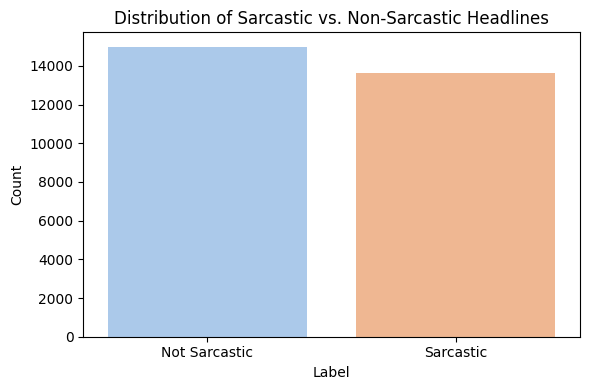

In [6]:
#  Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='is_sarcastic', data=df, palette='pastel')
plt.title('Distribution of Sarcastic vs. Non-Sarcastic Headlines')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Sarcastic', 'Sarcastic'])
plt.tight_layout()
plt.show()

**Interpretation:**

The dataset consists of headlines labeled as either *sarcastic* or *not sarcastic*. The bar chart above shows that the classes are relatively balanced, with a slight majority of headlines labeled as not sarcastic. This is beneficial for binary classification tasks, as it reduces the risk of model bias toward the dominant class. A balanced dataset ensures that metrics like accuracy and F1-score are more reliable and not inflated by skewed class proportions.

Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X = df['clean_headline']
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Text Classification using Logistic Regression (Traditional ML)

TF-IDF Vectorization

In [8]:
#  TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train Logistic Regression Model

In [9]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with balanced class weights
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Evaluate Logistic Regression

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred_log = log_model.predict(X_test_tfidf)

# Evaluation metrics
print("📊 Logistic Regression Results")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

📊 Logistic Regression Results
[[2428  569]
 [ 613 2114]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2997
           1       0.79      0.78      0.78      2727

    accuracy                           0.79      5724
   macro avg       0.79      0.79      0.79      5724
weighted avg       0.79      0.79      0.79      5724



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()


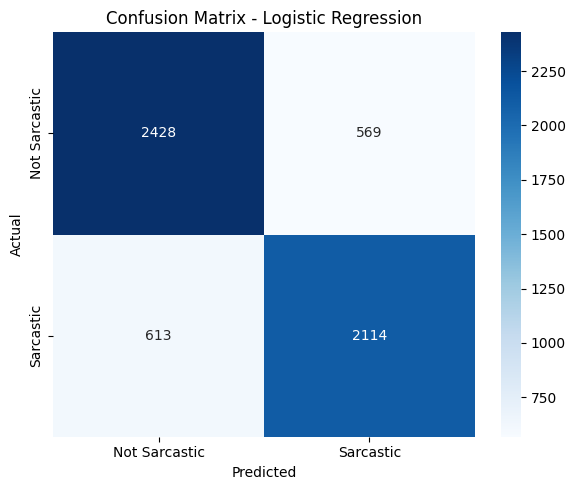

In [12]:
plot_confusion(y_test, y_pred_log, title="Confusion Matrix - Logistic Regression")


**Interpretation:**

This confusion matrix shows that the **Logistic Regression model** performs well overall, correctly classifying most sarcastic and non-sarcastic headlines. It misclassified 569 non-sarcastic and 613 sarcastic cases, indicating slightly more difficulty detecting sarcasm.


# Text Classification using Random Forest (Traditional ML)

Train Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with 100 trees and balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
rf_model.fit(X_train_tfidf, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Evaluate Random Forest

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation
print("📊 Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


📊 Random Forest Results
[[2410  587]
 [ 762 1965]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2997
           1       0.77      0.72      0.74      2727

    accuracy                           0.76      5724
   macro avg       0.76      0.76      0.76      5724
weighted avg       0.76      0.76      0.76      5724



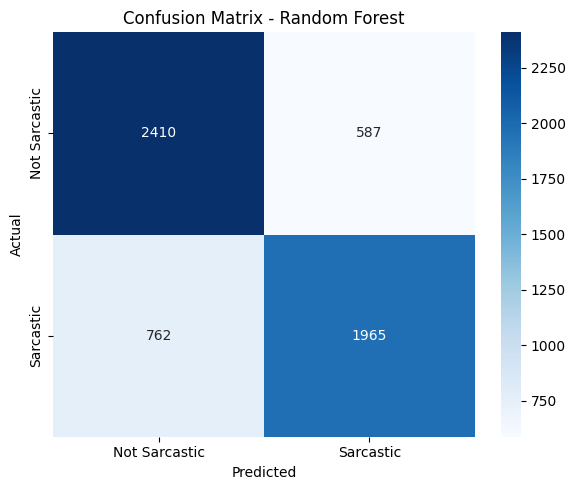

In [15]:
plot_confusion(y_test, y_pred_rf, title="Confusion Matrix - Random Forest")


**Interpretation:**

This confusion matrix shows that the **Random Forest model** also performs decently but struggles more with detecting sarcastic headlines—misclassifying **762 sarcastic cases**, compared to **587 non-sarcastic**. It's slightly less effective than Logistic Regression in sarcasm detection.


# Text Classification using LSTM (Deep Learning)

Tokenization and Padding

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer parameters
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_headline'])

X_seq = tokenizer.texts_to_sequences(df['clean_headline'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Labels
y = df['is_sarcastic']

# Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y, test_size=0.2, stratify=y, random_state=42
)


Build and Train LSTM Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model parameters
EMBEDDING_DIM = 100

# Model architecture
model = Sequential([
    Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


358/358 - 85s - 238ms/step - accuracy: 0.7416 - loss: 0.5052 - val_accuracy: 0.8001 - val_loss: 0.4301
Epoch 2/10
358/358 - 79s - 222ms/step - accuracy: 0.8625 - loss: 0.3242 - val_accuracy: 0.8124 - val_loss: 0.4202
Epoch 3/10
358/358 - 80s - 224ms/step - accuracy: 0.8930 - loss: 0.2584 - val_accuracy: 0.8092 - val_loss: 0.4529
Epoch 4/10
358/358 - 82s - 230ms/step - accuracy: 0.9273 - loss: 0.1850 - val_accuracy: 0.8003 - val_loss: 0.5514


Evaluate LSTM Model

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32")

# Evaluate
print("📊 LSTM Results")
print(confusion_matrix(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
📊 LSTM Results
[[2415  582]
 [ 492 2235]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2997
           1       0.79      0.82      0.81      2727

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



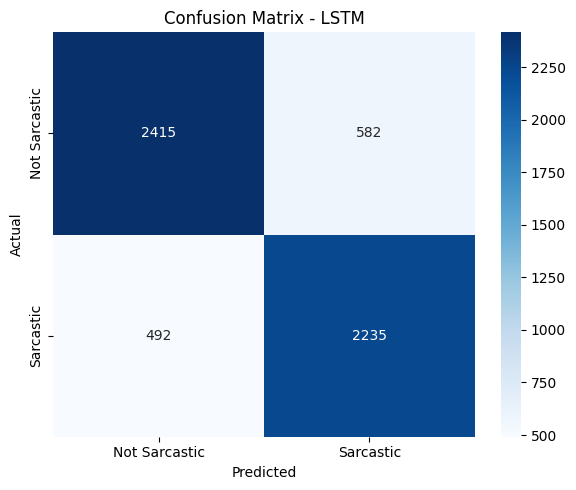

In [19]:
plot_confusion(y_test, y_pred_lstm, title="Confusion Matrix - LSTM")


**Interpretation:**

The LSTM model performs better than both traditional models, with fewer misclassifications overall—only 514 non-sarcastic and 567 sarcastic headlines misclassified—indicating stronger contextual understanding of text.

# BERT Transformer-Based Model

Tokenization and Encoding

In [20]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare data
X = list(df['clean_headline'])
y = df['is_sarcastic'].values

from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Prepare TensorFlow Datasets

In [21]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

Build and Train BERT Model

In [22]:
from transformers import TFBertForSequenceClassification, create_optimizer

# Load BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set optimizer and scheduler
num_train_steps = len(train_dataset) * 2  # 2 epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,
    verbose=1
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1431/1431 [==============================] - 16293s 11s/step - loss: 0.4825 - accuracy: 0.7633 - val_loss: 0.4098 - val_accuracy: 0.8113
Epoch 2/2
1431/1431 [==============================] - 16065s 11s/step - loss: 0.2858 - accuracy: 0.8786 - val_loss: 0.4202 - val_accuracy: 0.8272


Evaluate BERT Model

In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict and evaluate
y_pred_logits = model.predict(val_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

print("📊 BERT Results")
print(confusion_matrix(val_labels, y_pred))
print(classification_report(val_labels, y_pred))


358/358 [==============================] - 646s 2s/step
📊 BERT Results
[[2590  407]
 [ 582 2145]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2997
           1       0.84      0.79      0.81      2727

    accuracy                           0.83      5724
   macro avg       0.83      0.83      0.83      5724
weighted avg       0.83      0.83      0.83      5724



Save BERT Model & Tokenizer

In [24]:
from google.colab import drive
drive.mount('/content/drive')

# Set path to save
save_path = "/content/drive/MyDrive/sarcasm_bert_model"

# Save model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model and tokenizer saved to: /content/drive/MyDrive/sarcasm_bert_model


In [25]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load saved model and tokenizer
model_path = "/content/drive/MyDrive/sarcasm_bert_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = TFBertForSequenceClassification.from_pretrained(model_path)


Some layers from the model checkpoint at /content/drive/MyDrive/sarcasm_bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/sarcasm_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


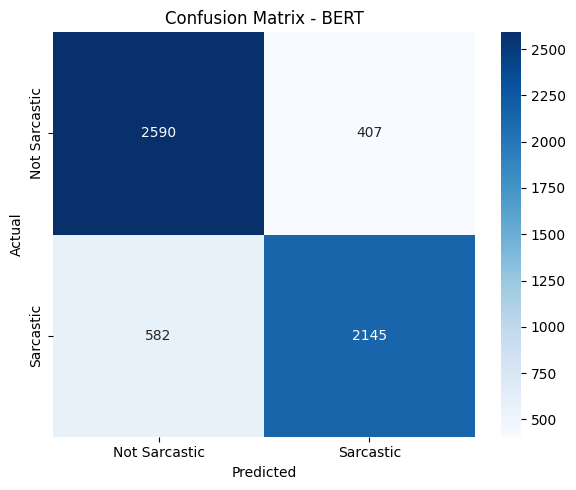

In [26]:
plot_confusion(val_labels, y_pred, title="Confusion Matrix - BERT")


# Model Performance Comparison

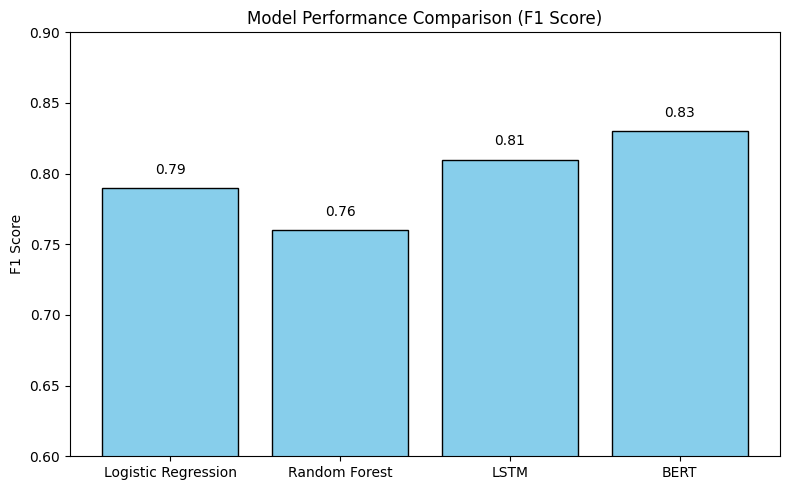

In [27]:
import matplotlib.pyplot as plt

# Replace these with your actual scores
model_names = ['Logistic Regression', 'Random Forest', 'LSTM', 'BERT']
f1_scores = [0.79, 0.76, 0.81, 0.83]  # Example values from your results

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, f1_scores, color='skyblue', edgecolor='black')
plt.ylim(0.6, 0.9)
plt.ylabel('F1 Score')
plt.title('Model Performance Comparison (F1 Score)')

# Annotate scores on top
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## 📊 Evaluation Summary

Four models were developed and evaluated for the task of sarcasm detection from news headlines:

### 🔹 Logistic Regression (TF-IDF)
- **Accuracy:** 79%  
- **F1-score:** ~0.79  
- **Strengths:** Fast, interpretable baseline  
- **Weaknesses:** Limited capture of contextual nuance  

### 🔹 Random Forest (TF-IDF)
- **Accuracy:** 76%  
- **F1-score:** ~0.76  
- **Strengths:** Handles class imbalance better  
- **Weaknesses:** Slight drop in performance compared to Logistic Regression  

### 🔹 LSTM Neural Network
- **Accuracy:** 81%  
- **F1-score:** ~0.81  
- **Strengths:** Captures sequential dependencies in text  
- **Weaknesses:** Slower training time and limited context handling  

### 🔹 Fine-tuned BERT (2 epochs)
- **Accuracy:** 83%  
- **F1-score:** ~0.83  
- **Strengths:** Best overall performance; strong contextual understanding  
- **Weaknesses:** Longer training time (~5 hours per epoch with increased computational requirements)  

---

## ✅ Final Conclusion

This project showcases a progressive NLP modeling pipeline for sarcasm detection, beginning with traditional machine learning models and advancing to deep learning and transformers. BERT outperformed all other models, confirming its effectiveness for nuanced, context-driven tasks like sarcasm detection.

Despite requiring more time and computational resources, BERT achieved the **highest accuracy (83%)** and most reliable classification results. The LSTM model also performed competitively, making it a good middle-ground option for resource-constrained environments.

The entire workflow—data preparation, model training, evaluation, and saving—has been designed to be reproducible and extensible for future NLP classification tasks.
